# Tutorial: Flood risk from bed aggradation and spatially variable infiltration

In [1]:
###################################
# Import necessary repositories
###################################
%reset -f
from landlab.components.overland_flow import OverlandFlow
from landlab.components import SoilInfiltrationGreenAmpt
from landlab import RasterModelGrid
from landlab.io.esri_ascii import read_esri_ascii
from matplotlib.pyplot import figure
import numpy as np
from time import time
from os import system

# Sediment Network Stuff
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.plot import plot_network_and_parcels
import warnings
warnings.filterwarnings('ignore')

# Plotting and visualization
import matplotlib.pyplot as plt
from landlab.plot.imshow import imshow_grid
import matplotlib.colors as mcolors
colors = [(0,0,1,i) for i in np.linspace(0,1,3)]
WaterMap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)
from landlab.plot.colors import water_colormap

#Hillshading
from matplotlib.colors import LightSource


In [2]:
###################################
# Global parameters
###################################

run_time = 100  # duration of run, (s)
h_init = 0      # initial thin layer of water (m)
n = 0.01        # roughness coefficient, (s/m^(1/3))
g = 9.8         # gravity (m/s^2)
alpha = 0.7     # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4         # constant velocity (m/s, de Almeida et al., 2012)

run_time_slices = (10, 50, 100)
elapsed_time = 1.0

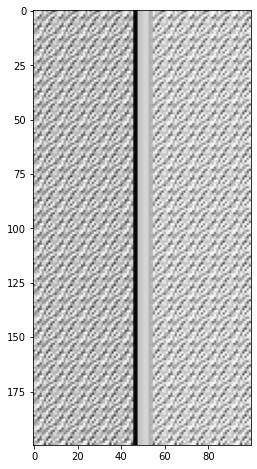

In [3]:
###################################
# 2D lowland domain
###################################

#Define grid
nX = 200
nY = 100
spacing = 1.0
Datum = 500
grid = RasterModelGrid((nX, nY), xy_spacing=1.)

# Pointer to topographic elevation > z
z = np.ones(nX*nY) * Datum
z = grid.add_field('topographic__elevation', z, at='node')

# Add a longitudinal slope 
## (makes thing flow north to south)
Long_Slope = 1./1000
z += grid.node_y*Long_Slope

# Add the channel indentation 
## (it's just a straigth strip)
Channel_Width = 8.
Channel_Depth = 2.

isChannel = (grid.node_x > (nY/2 - Channel_Width/2)) * (grid.node_x < (nY/2 + Channel_Width/2))
z[isChannel] -= Channel_Depth

# Add a slope to the banks
## (so water flows always towards the main channel)
Transversal_Slope = 1./100
z += np.abs(grid.node_x-(nY/2))*Transversal_Slope

# Add some random noise to the floodplains
## (makes the hillshading look prettier)
z += ~isChannel * np.reshape(np.tile(np.random.rand(10,10)*0.20,[int(nX/10),int(nY/10)]),nX*nY) 

# Plot 2D domain topography
fig = plt.figure(figsize=(10,8))
ls = LightSource(azdeg=315, altdeg=45)
plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray')
plt.show()

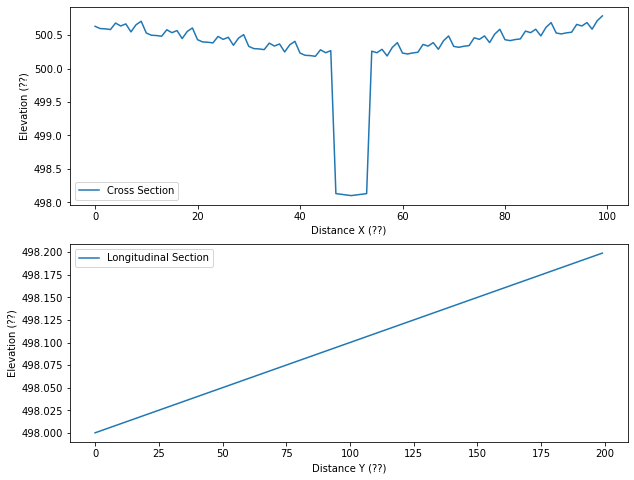

In [4]:
# Check the 2D domain topography
fig = plt.figure(figsize=(10,8))

## Cross Section
ax1 = plt.subplot(2,1,1)
ax1.plot(grid.node_x[grid.node_y==nX/2],z[grid.node_y==nX/2],label="Cross Section")
ax1.set_ylabel("Elevation (??)")
ax1.set_xlabel("Distance X (??)")
ax1.legend()

## Long Section
ax2 = plt.subplot(2,1,2)
ax2.plot(grid.node_y[grid.node_x==nY/2],z[grid.node_x==nY/2],label="Longitudinal Section")
ax2.set_ylabel("Elevation (??)")
ax2.set_xlabel("Distance Y (??)")
ax2.legend()

fig.show()

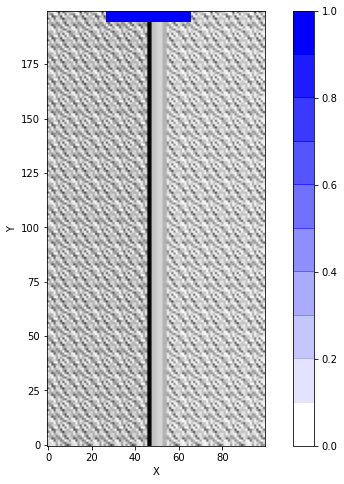

In [5]:
###################################
# 2D lowland water depths
###################################

# Pointer to surface water depth in the 2D floodplain
h = np.zeros(nX*nY)
bools = (grid.node_x > nY/2 - Channel_Width*3) * (grid.node_x < nY/2 + Channel_Width*2) * (grid.node_y >= nX-5)
h[bools] = Channel_Depth*0.5
h += h_init
h = grid.add_field('surface_water__depth', h, at='node')

# Plot 2D domain water elevation
fig = plt.figure(figsize=(10,8))
plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
imshow_grid(grid,'surface_water__depth',cmap=WaterMap,vmin=0,vmax=max(h))
fig.show()

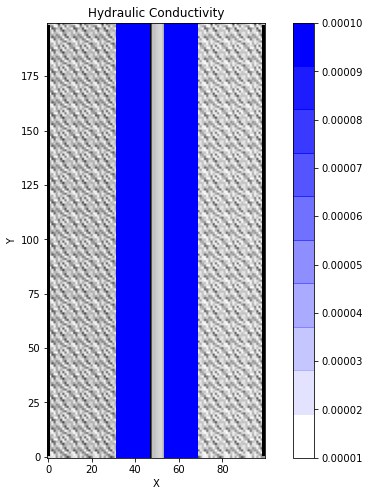

In [6]:
#####################################
# Boundary conditions
#####################################
grid.set_closed_boundaries_at_grid_edges(True, False, True, False)
np.all(grid.at_node['topographic__elevation'] == z)

#####################################
# Spatially variable hydraulic cond. 
#####################################
d = grid.add_ones("soil_water_infiltration__depth", at="node", dtype=float)
d *= 0.2

hc = grid.add_ones('hydraulic_conductivity', at='node')
hc *= 1.0E-5

infBandWidthNorm = 0.3
infBandWidth = nY/2 * infBandWidthNorm

channel_left = (nY + Channel_Width) / 2
channel_right = (nY - Channel_Width) / 2

#Define high infiltration bands at the banks
highInfBand = np.logical_and(grid.x_of_node < channel_left + infBandWidth, grid.x_of_node > channel_right - infBandWidth)
inf_mask = np.logical_xor(highInfBand, isChannel)
hc[inf_mask] *= 10

# Plot 2D domain hydraulic cond.
fig = plt.figure(figsize=(10,8))
plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
imshow_grid(grid,'hydraulic_conductivity',cmap=WaterMap)
plt.title("Hydraulic Conductivity")
fig.show()

In [7]:
# Initialize model components
of = OverlandFlow(grid, steep_slopes=True)
SI = SoilInfiltrationGreenAmpt(grid, hydraulic_conductivity=hc)

Elapsed time:  0
Elapsed time:  9.39308703577
Elapsed time:  18.0507287123
Elapsed time:  26.2947119374
Elapsed time:  34.1245109751
Elapsed time:  41.7032902266
Elapsed time:  48.993627674
Elapsed time:  56.0648108993
Elapsed time:  63.1079187457
Elapsed time:  70.0023296025
Elapsed time:  76.8010118836
Elapsed time:  83.6323511612
Elapsed time:  90.4839273462
Elapsed time:  97.2157666246
Elapsed time:  103.873669565
Elapsed time:  110.517258089
Elapsed time:  117.157904849
Elapsed time:  123.793920833
Elapsed time:  130.373846612
Elapsed time:  136.999299601
Elapsed time:  143.630507627
Elapsed time:  150.203355709
Elapsed time:  156.777758016
Elapsed time:  163.405497997
Elapsed time:  169.984001213
Elapsed time:  176.577343636
Elapsed time:  183.193536648
Elapsed time:  189.824828639
Elapsed time:  196.42719512


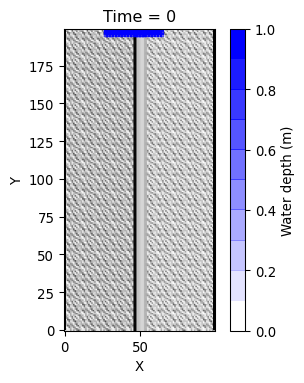

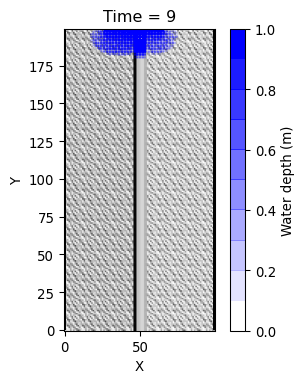

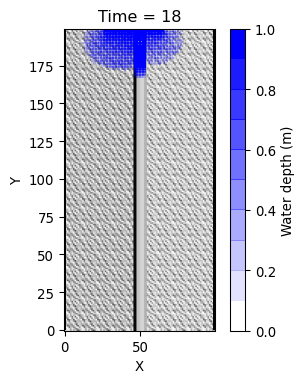

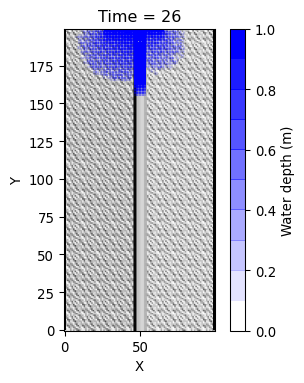

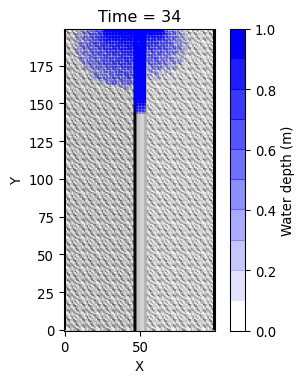

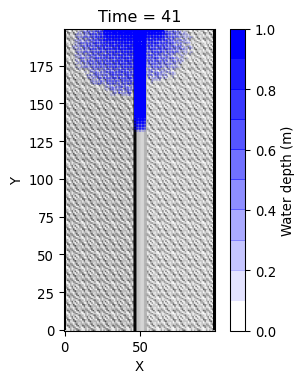

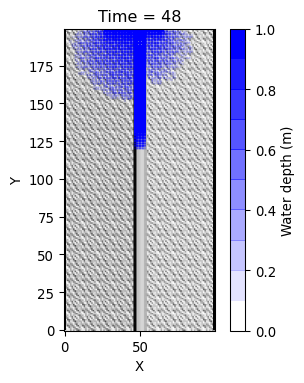

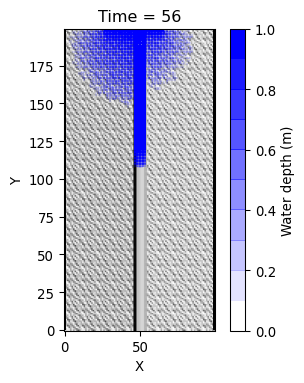

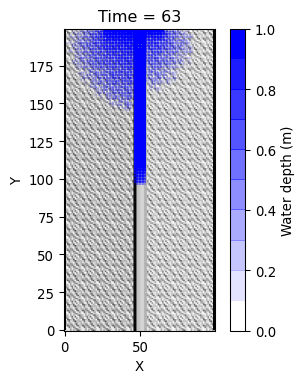

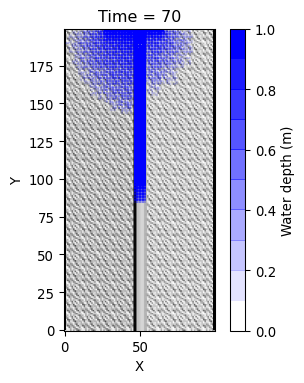

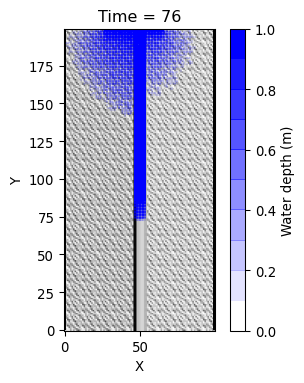

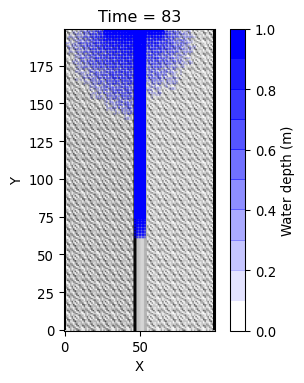

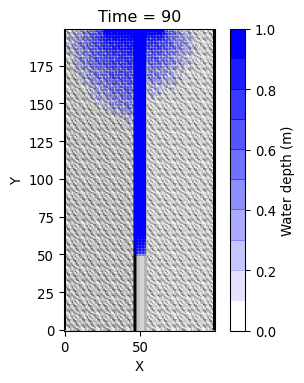

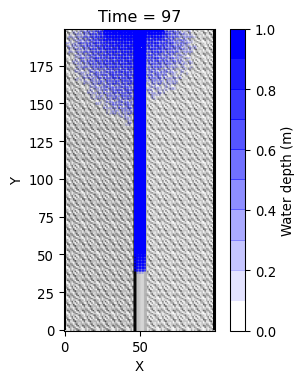

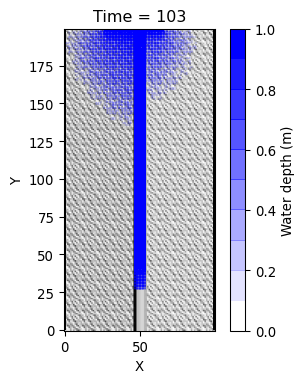

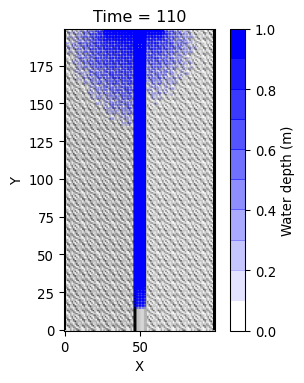

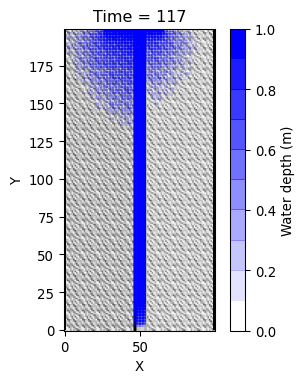

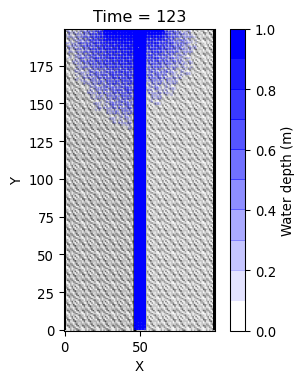

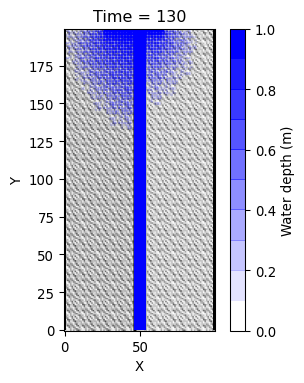

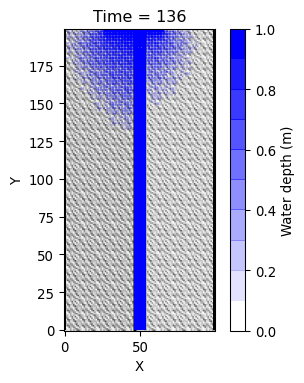

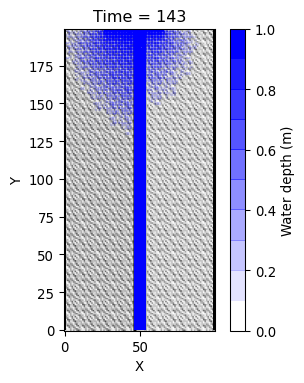

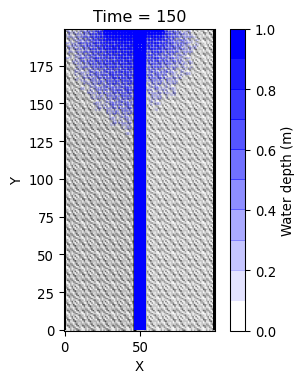

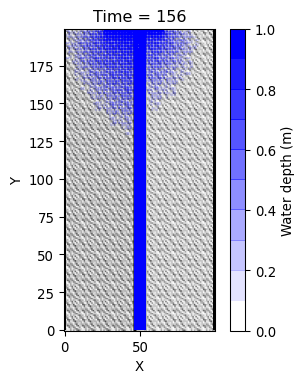

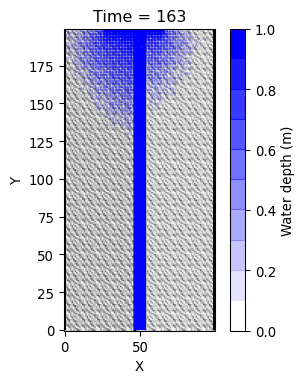

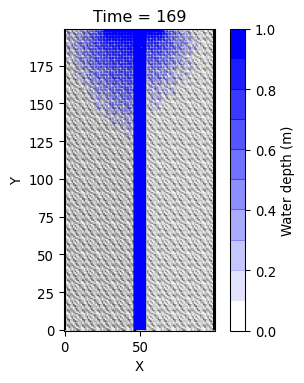

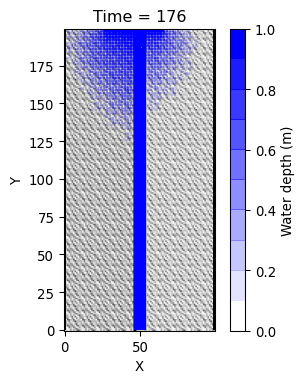

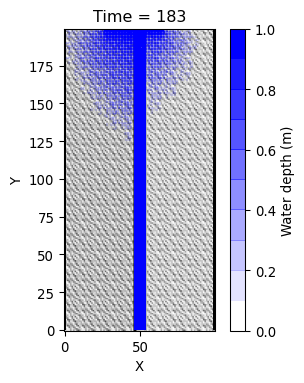

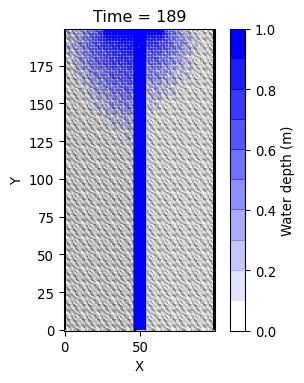

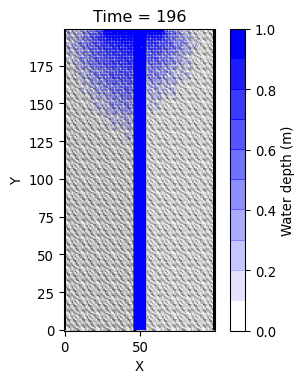

In [8]:
elapsed_time = 0
run_time = 200
iters = 0

#Figure outputs
mydpi = 96
sizeFigure = 400
system("rm -r ResultImages/*.png")

while elapsed_time < run_time:
    
    # First, we calculate our time step.
    dt = of.calc_time_step()
    # Now, we can generate overland flow.
    of.overland_flow()
    SI.run_one_step(dt)
    
    if iters %50==0:
        print('Elapsed time: ', elapsed_time)
        fig = plt.figure(figsize=(sizeFigure/mydpi, sizeFigure/mydpi), dpi=mydpi)
        plt.imshow(ls.hillshade(np.reshape(z,[nX,nY]), vert_exag=10), cmap='gray',origin="lower")
        imshow_grid(grid,'surface_water__depth',\
                    limits=(0,1),cmap=WaterMap,\
                    colorbar_label="Water depth (m)",\
                    plot_name="Time = %i" %elapsed_time)
        fig.savefig("ResultImages/" + str(iters).zfill(5) + ".png")
    
    elapsed_time += dt
    iters += 1

In [11]:
###################################
# 2D lowland water depths
###################################

import imageio
from glob import glob

images=[]
original_files=list(glob("./ResultImages/*.png"))
original_files.sort(reverse=False)
for file_ in original_files:
    images.append(imageio.imread(file_))
imageio.mimsave('./animation.gif', images, duration=1/5, subrectangles=True)